Link to dataset: https://www.kaggle.com/code/egenius/starter-cert-insider-threat-cfc11c55-1/input

<h1>Imported Libraries</h1>

In [26]:
import pandas as pd
import re
import string
import nltk
from scipy import stats
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import StandardScaler

from textblob import TextBlob
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Download the Punkt Tokenizer Models (only need to do this once)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OnilChibaya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h1>Preprocessing</h1>

<h4>Import Dataset</h4>

In [27]:
dataset = pd.read_csv('email.csv')
dataset.head(5)

,id,date,user,pc,to,cc,bcc,from,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010 07:11:45,LAP0338,PC-5758,Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...,Nathaniel.Hunter.Heath@dtaa.com,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010 07:12:16,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,NaN,NaN,MOH68@optonline.net,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010 07:13:00,LAP0338,PC-5758,Penelope_Colon@netzero.com,NaN,NaN,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010 07:13:17,LAP0338,PC-5758,Judith_Hayden@comcast.net,NaN,NaN,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010 07:13:28,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,NaN,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...


<h4>Pre-preprocessing</h4>

Below we convert categorical data to numeric data and restructuring the dataset before diving in to the preprocessing of the dataset.

In [28]:
# Split the 'datetime' column into 'date' and 'time' columns
split_df = dataset['date'].str.split(' ', expand=True)
dataset['date'] = split_df[0]
dataset['time'] = split_df[1].fillna('00:00:00')  # Fill missing time values with a default time if needed
dataset.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,time
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010,LAP0338,PC-5758,Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...,Nathaniel.Hunter.Heath@dtaa.com,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...,07:11:45
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,NaN,NaN,MOH68@optonline.net,29942,0,the breaking called allied reservations former...,07:12:16
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010,LAP0338,PC-5758,Penelope_Colon@netzero.com,NaN,NaN,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...,07:13:00
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010,LAP0338,PC-5758,Judith_Hayden@comcast.net,NaN,NaN,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...,07:13:17
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,NaN,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...,07:13:28


In [29]:
# Convert email addresses to the number of addresses in each row
dataset['to'] = dataset['to'].str.count(';') + 1
dataset.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,time
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010,LAP0338,PC-5758,2,Nathaniel.Hunter.Heath@dtaa.com,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...,07:11:45
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010,MOH0273,PC-6699,1,NaN,NaN,MOH68@optonline.net,29942,0,the breaking called allied reservations former...,07:12:16
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010,LAP0338,PC-5758,1,NaN,NaN,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...,07:13:00
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010,LAP0338,PC-5758,1,NaN,NaN,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...,07:13:17
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010,MOH0273,PC-6699,3,NaN,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...,07:13:28


In [30]:
# Convert email addresses to the number of addresses in each row
dataset['cc'] = dataset['cc'].apply(lambda x: x.count(';') + 1 if pd.notna(x) else 0)
dataset.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,time
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010,LAP0338,PC-5758,2,1,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...,07:11:45
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010,MOH0273,PC-6699,1,0,NaN,MOH68@optonline.net,29942,0,the breaking called allied reservations former...,07:12:16
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010,LAP0338,PC-5758,1,0,NaN,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...,07:13:00
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010,LAP0338,PC-5758,1,0,NaN,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...,07:13:17
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010,MOH0273,PC-6699,3,0,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...,07:13:28


In [31]:
# Convert email addresses to the number of addresses in each row
dataset['bcc'] = dataset['bcc'].apply(lambda x: x.count(';') + 1 if pd.notna(x) else 0)
dataset.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,time
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010,LAP0338,PC-5758,2,1,0,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...,07:11:45
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010,MOH0273,PC-6699,1,0,0,MOH68@optonline.net,29942,0,the breaking called allied reservations former...,07:12:16
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010,LAP0338,PC-5758,1,0,0,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...,07:13:00
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010,LAP0338,PC-5758,1,0,0,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...,07:13:17
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010,MOH0273,PC-6699,3,0,1,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...,07:13:28


In [32]:
# Convert the text in 'from' to lowercase
dataset['from'] = dataset['from'].str.lower()
dataset.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,time
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010,LAP0338,PC-5758,2,1,0,lynn.adena.pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...,07:11:45
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010,MOH0273,PC-6699,1,0,0,moh68@optonline.net,29942,0,the breaking called allied reservations former...,07:12:16
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010,LAP0338,PC-5758,1,0,0,lynn_a_pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...,07:13:00
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010,LAP0338,PC-5758,1,0,0,lynn_a_pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...,07:13:17
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010,MOH0273,PC-6699,3,0,1,moh68@optonline.net,17319,0,this kmh october holliswood number advised unu...,07:13:28


In [33]:
# Convert the text in 'content' to lowercase
dataset['content'] = dataset['content'].str.lower()
dataset.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,time
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010,LAP0338,PC-5758,2,1,0,lynn.adena.pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...,07:11:45
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010,MOH0273,PC-6699,1,0,0,moh68@optonline.net,29942,0,the breaking called allied reservations former...,07:12:16
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010,LAP0338,PC-5758,1,0,0,lynn_a_pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...,07:13:00
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010,LAP0338,PC-5758,1,0,0,lynn_a_pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...,07:13:17
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010,MOH0273,PC-6699,3,0,1,moh68@optonline.net,17319,0,this kmh october holliswood number advised unu...,07:13:28


In [34]:
# Rearrange columns
dataset = dataset[['id', 'pc', 'user', 'date', 'time', 'from', 'to', 'cc', 'bcc', 'size', 'attachments', 'content']]
dataset.head()

,id,pc,user,date,time,from,to,cc,bcc,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},PC-5758,LAP0338,01/02/2010,07:11:45,lynn.adena.pratt@dtaa.com,2,1,0,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},PC-6699,MOH0273,01/02/2010,07:12:16,moh68@optonline.net,1,0,0,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},PC-5758,LAP0338,01/02/2010,07:13:00,lynn_a_pratt@earthlink.net,1,0,0,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},PC-5758,LAP0338,01/02/2010,07:13:17,lynn_a_pratt@earthlink.net,1,0,0,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},PC-6699,MOH0273,01/02/2010,07:13:28,moh68@optonline.net,3,0,1,17319,0,this kmh october holliswood number advised unu...


<h1>Preprocessing</h1>

convert date and time to numerical data for the standardization and normalization process.

In [35]:
# Remove '/' from the 'date'
dataset['date'] = dataset['date'].str.replace('/', '')
dataset

,id,pc,user,date,time,from,to,cc,bcc,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},PC-5758,LAP0338,01022010,07:11:45,lynn.adena.pratt@dtaa.com,2,1,0,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},PC-6699,MOH0273,01022010,07:12:16,moh68@optonline.net,1,0,0,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},PC-5758,LAP0338,01022010,07:13:00,lynn_a_pratt@earthlink.net,1,0,0,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},PC-5758,LAP0338,01022010,07:13:17,lynn_a_pratt@earthlink.net,1,0,0,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},PC-6699,MOH0273,01022010,07:13:28,moh68@optonline.net,3,0,1,17319,0,this kmh october holliswood number advised unu...
...,...,...,...,...,...,...,...,...,...,...,...,...
2629974,{L7U1-S3KK01XW-3123TPUC},PC-1117,HRL0540,05162011,20:54:18,hedwig.regina.livingston@dtaa.com,2,1,0,33088,0,history designed stephen degree ignore them ad...
2629975,{Q4Y3-X9HV77CL-3290SOZH},PC-4973,LAF0991,05162011,20:54:43,lucas.ahmed.ferrell@dtaa.com,1,2,0,33249,1,prince prince ahmose ahmose ankh prince prince...
2629976,{L6B7-F7RU89CD-0355JGGE},PC-4973,LAF0991,05162011,21:08:12,ferrell.lucas@sbcglobal.net,2,0,0,41336,1,lifted documents 65 declined revival 14 unprec...
2629977,{F4R9-W0OQ41HB-0157JSUE},PC-1397,JMW0638,05162011,21:15:35,jonah.merritt.wilder@dtaa.com,1,0,0,39908,0,their official holmes face arranged among priz...


In [36]:
# Remove ':' from the 'time'
dataset['time'] = dataset['time'].str.replace(':', '')
dataset

,id,pc,user,date,time,from,to,cc,bcc,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},PC-5758,LAP0338,01022010,071145,lynn.adena.pratt@dtaa.com,2,1,0,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},PC-6699,MOH0273,01022010,071216,moh68@optonline.net,1,0,0,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},PC-5758,LAP0338,01022010,071300,lynn_a_pratt@earthlink.net,1,0,0,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},PC-5758,LAP0338,01022010,071317,lynn_a_pratt@earthlink.net,1,0,0,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},PC-6699,MOH0273,01022010,071328,moh68@optonline.net,3,0,1,17319,0,this kmh october holliswood number advised unu...
...,...,...,...,...,...,...,...,...,...,...,...,...
2629974,{L7U1-S3KK01XW-3123TPUC},PC-1117,HRL0540,05162011,205418,hedwig.regina.livingston@dtaa.com,2,1,0,33088,0,history designed stephen degree ignore them ad...
2629975,{Q4Y3-X9HV77CL-3290SOZH},PC-4973,LAF0991,05162011,205443,lucas.ahmed.ferrell@dtaa.com,1,2,0,33249,1,prince prince ahmose ahmose ankh prince prince...
2629976,{L6B7-F7RU89CD-0355JGGE},PC-4973,LAF0991,05162011,210812,ferrell.lucas@sbcglobal.net,2,0,0,41336,1,lifted documents 65 declined revival 14 unprec...
2629977,{F4R9-W0OQ41HB-0157JSUE},PC-1397,JMW0638,05162011,211535,jonah.merritt.wilder@dtaa.com,1,0,0,39908,0,their official holmes face arranged among priz...


Converting the PC- column to niumeric by removing the PC- string and keeping the PC value only.

In [37]:
# Remove the "PC-" prefix
dataset['pc'] = dataset['pc'].str.replace('PC-', '')
dataset

,id,pc,user,date,time,from,to,cc,bcc,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},5758,LAP0338,01022010,071145,lynn.adena.pratt@dtaa.com,2,1,0,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},6699,MOH0273,01022010,071216,moh68@optonline.net,1,0,0,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},5758,LAP0338,01022010,071300,lynn_a_pratt@earthlink.net,1,0,0,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},5758,LAP0338,01022010,071317,lynn_a_pratt@earthlink.net,1,0,0,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},6699,MOH0273,01022010,071328,moh68@optonline.net,3,0,1,17319,0,this kmh october holliswood number advised unu...
...,...,...,...,...,...,...,...,...,...,...,...,...
2629974,{L7U1-S3KK01XW-3123TPUC},1117,HRL0540,05162011,205418,hedwig.regina.livingston@dtaa.com,2,1,0,33088,0,history designed stephen degree ignore them ad...
2629975,{Q4Y3-X9HV77CL-3290SOZH},4973,LAF0991,05162011,205443,lucas.ahmed.ferrell@dtaa.com,1,2,0,33249,1,prince prince ahmose ahmose ankh prince prince...
2629976,{L6B7-F7RU89CD-0355JGGE},4973,LAF0991,05162011,210812,ferrell.lucas@sbcglobal.net,2,0,0,41336,1,lifted documents 65 declined revival 14 unprec...
2629977,{F4R9-W0OQ41HB-0157JSUE},1397,JMW0638,05162011,211535,jonah.merritt.wilder@dtaa.com,1,0,0,39908,0,their official holmes face arranged among priz...


In [38]:
# Rearrange columns
dataset = dataset[['id', 'user', 'from', 'pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'content']]
dataset.head()

,id,user,from,pc,date,time,to,cc,bcc,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},LAP0338,lynn.adena.pratt@dtaa.com,5758,01022010,071145,2,1,0,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},MOH0273,moh68@optonline.net,6699,01022010,071216,1,0,0,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},LAP0338,lynn_a_pratt@earthlink.net,5758,01022010,071300,1,0,0,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},LAP0338,lynn_a_pratt@earthlink.net,5758,01022010,071317,1,0,0,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},MOH0273,moh68@optonline.net,6699,01022010,071328,3,0,1,17319,0,this kmh october holliswood number advised unu...


Feature Engineering

In [39]:
# Character Count:
dataset['char_count'] = dataset['content'].apply(len)

# Word Count:
dataset['word_count'] = dataset['content'].apply(lambda x: len(x.split()))

# Average Word Length:
dataset['avg_word_length'] = dataset['content'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)

# Counting the number of sentences
dataset['sentence_count'] = dataset['content'].apply(lambda x: len(sent_tokenize(x)))

C:\Users\OnilChibaya\AppData\Local\Temp\ipykernel_4224\3383959473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['char_count'] = dataset['content'].apply(len)
C:\Users\OnilChibaya\AppData\Local\Temp\ipykernel_4224\3383959473.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['word_count'] = dataset['content'].apply(lambda x: len(x.split()))
C:\Users\OnilChibaya\AppData\Local\Temp\ipykernel_4224\3383959473.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [40]:
# Rearrange columns
dataset = dataset[['id', 'user', 'from', 'pc','date', 'time', 'to', 'cc', 'bcc', 'size', 'attachments', 'char_count', 'word_count', 'avg_word_length', 'sentence_count', 'content']]
dataset.head()

,id,user,from,pc,date,time,to,cc,bcc,size,attachments,char_count,word_count,avg_word_length,sentence_count,content
0,{R3I7-S4TX96FG-8219JWFF},LAP0338,lynn.adena.pratt@dtaa.com,5758,01022010,071145,2,1,0,25830,0,415,63,5.603175,1,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},MOH0273,moh68@optonline.net,6699,01022010,071216,1,0,0,29942,0,307,43,6.162791,1,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},LAP0338,lynn_a_pratt@earthlink.net,5758,01022010,071300,1,0,0,28780,0,279,40,6.000000,1,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},LAP0338,lynn_a_pratt@earthlink.net,5758,01022010,071317,1,0,0,21907,0,359,49,6.346939,1,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},MOH0273,moh68@optonline.net,6699,01022010,071328,3,0,1,17319,0,364,50,6.300000,1,this kmh october holliswood number advised unu...


Standardization

Before standardizing the data, we have to convert the pc, date and time varialbles to type int64

In [41]:
# Convert column 'pc', 'date' and time to int64
dataset['pc'] = dataset['pc'].astype('int64')

dataset['date'] = dataset['date'].astype('int64')

dataset['time'] = dataset['time'].astype('int64')
dataset.head()

,id,user,from,pc,date,time,to,cc,bcc,size,attachments,char_count,word_count,avg_word_length,sentence_count,content
0,{R3I7-S4TX96FG-8219JWFF},LAP0338,lynn.adena.pratt@dtaa.com,5758,1022010,71145,2,1,0,25830,0,415,63,5.603175,1,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},MOH0273,moh68@optonline.net,6699,1022010,71216,1,0,0,29942,0,307,43,6.162791,1,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},LAP0338,lynn_a_pratt@earthlink.net,5758,1022010,71300,1,0,0,28780,0,279,40,6.000000,1,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},LAP0338,lynn_a_pratt@earthlink.net,5758,1022010,71317,1,0,0,21907,0,359,49,6.346939,1,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},MOH0273,moh68@optonline.net,6699,1022010,71328,3,0,1,17319,0,364,50,6.300000,1,this kmh october holliswood number advised unu...


In [42]:
# Identify numeric columns
numeric_columns = dataset.select_dtypes(include=['float64', 'int64']).columns

# Standardize numeric columns
scaler = StandardScaler()
dataset[numeric_columns] = scaler.fit_transform(dataset[numeric_columns])
dataset.head()

,id,user,from,pc,date,time,to,cc,bcc,size,attachments,char_count,word_count,avg_word_length,sentence_count,content
0,{R3I7-S4TX96FG-8219JWFF},LAP0338,lynn.adena.pratt@dtaa.com,0.225155,-1.350869,-1.776521,0.391517,0.657642,-0.422412,-0.416497,-0.38441,0.799004,1.347242,-1.226924,0.0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},MOH0273,moh68@optonline.net,0.544371,-1.350869,-1.774182,-0.695123,-0.687330,-0.422412,-0.005035,-0.38441,-0.629780,-0.649797,-0.042513,0.0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},LAP0338,lynn_a_pratt@earthlink.net,0.225155,-1.350869,-1.771414,-0.695123,-0.687330,-0.422412,-0.121309,-0.38441,-1.000205,-0.949353,-0.387054,0.0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},LAP0338,lynn_a_pratt@earthlink.net,0.225155,-1.350869,-1.770854,-0.695123,-0.687330,-0.422412,-0.809047,-0.38441,0.058153,-0.050686,0.347231,0.0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},MOH0273,moh68@optonline.net,0.544371,-1.350869,-1.770491,1.478157,-0.687330,2.101201,-1.268139,-0.38441,0.124301,0.049166,0.247887,0.0,this kmh october holliswood number advised unu...


Identify numerical anomalies.

In [43]:
# Calculate Z-scores
z_scores = stats.zscore(dataset.select_dtypes(include=['float64', 'int64']))

# Get boolean DataFrame indicating the presence of anomalies (using a threshold, e.g., 2)
anomalies_bool_df = pd.DataFrame(z_scores, columns=dataset.select_dtypes(include=['float64', 'int64']).columns, index=dataset.index)
anomalies_bool_df = (anomalies_bool_df > 2) | (anomalies_bool_df < -2)

# Extract anomalies
anomalies = dataset[anomalies_bool_df.any(axis=1)]

# Drop anomalies from the original dataset
df_no_anomalies = dataset.drop(anomalies.index)

# Display the datasets
print("Normal Dataset:")
print(df_no_anomalies)
print("\nAnomalous Dataset:")
print(anomalies)

Normal Dataset:
                               id     user                             from  \
0        {R3I7-S4TX96FG-8219JWFF}  LAP0338        lynn.adena.pratt@dtaa.com   
1        {R0R9-E4GL59IK-2907OSWJ}  MOH0273              moh68@optonline.net   
2        {G2B2-A8XY58CP-2847ZJZL}  LAP0338       lynn_a_pratt@earthlink.net   
3        {A3A9-F4TH89AA-8318GFGK}  LAP0338       lynn_a_pratt@earthlink.net   
5        {X8T7-A6BT54FP-7241DLBV}  HVB0037        hollee_becker@hotmail.com   
...                           ...      ...                              ...   
2629876  {P4V8-L7RO47MY-3213UULA}  AMR0400   aurelia.martina.reese@dtaa.com   
2629877  {O1Z8-G3PF06XP-5478BCXH}  IAR0694        imani.aubrey.ray@dtaa.com   
2629879  {N1S7-E0NN19WN-8990TPMW}  IYB0918  illana.y.bradshaw@earthlink.net   
2629880  {E6T8-T3NA73UB-5296YCSP}  KMB0922           benson-keegan@juno.com   
2629881  {C8H6-E1SY12PC-3605SXAV}  IYB0918  illana.yvette.bradshaw@dtaa.com   

               pc      date      ti

In [44]:
df_no_anomalies['target'] = 0
anomalies['target'] = 1
# Combine dataframes vertically
dataset = pd.concat([df_no_anomalies, anomalies])

# Order by index
dataset = dataset.sort_index()
dataset.head()

C:\Users\OnilChibaya\AppData\Local\Temp\ipykernel_4224\1974082596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['target'] = 1


,id,user,from,pc,date,time,to,cc,bcc,size,attachments,char_count,word_count,avg_word_length,sentence_count,content,target
0,{R3I7-S4TX96FG-8219JWFF},LAP0338,lynn.adena.pratt@dtaa.com,0.225155,-1.350869,-1.776521,0.391517,0.657642,-0.422412,-0.416497,-0.38441,0.799004,1.347242,-1.226924,0.0,middle f2 systems 4 july techniques powerful d...,0
1,{R0R9-E4GL59IK-2907OSWJ},MOH0273,moh68@optonline.net,0.544371,-1.350869,-1.774182,-0.695123,-0.687330,-0.422412,-0.005035,-0.38441,-0.629780,-0.649797,-0.042513,0.0,the breaking called allied reservations former...,0
2,{G2B2-A8XY58CP-2847ZJZL},LAP0338,lynn_a_pratt@earthlink.net,0.225155,-1.350869,-1.771414,-0.695123,-0.687330,-0.422412,-0.121309,-0.38441,-1.000205,-0.949353,-0.387054,0.0,slowly this uncinus winter beneath addition ex...,0
3,{A3A9-F4TH89AA-8318GFGK},LAP0338,lynn_a_pratt@earthlink.net,0.225155,-1.350869,-1.770854,-0.695123,-0.687330,-0.422412,-0.809047,-0.38441,0.058153,-0.050686,0.347231,0.0,400 other difficult land cirrocumulus powered ...,0
4,{E8B7-C8FZ88UF-2946RUQQ},MOH0273,moh68@optonline.net,0.544371,-1.350869,-1.770491,1.478157,-0.687330,2.101201,-1.268139,-0.38441,0.124301,0.049166,0.247887,0.0,this kmh october holliswood number advised unu...,1


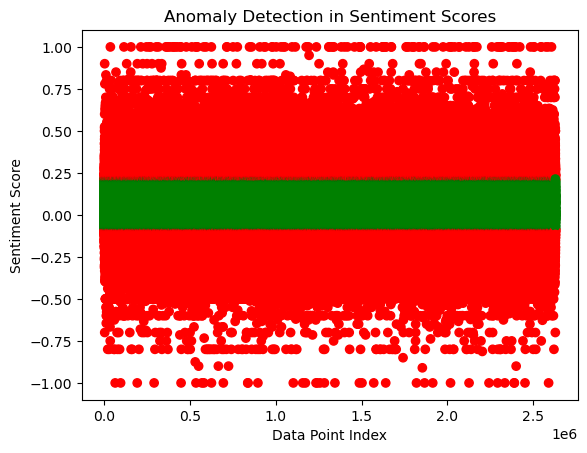

In [45]:
# Perform sentiment analysis and get polarity scores
df_no_anomalies['sentiment_score'] = df_no_anomalies['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Detect anomalies using Isolation Forest
clf = IsolationForest(contamination=0.2)
df_no_anomalies['anomaly'] = clf.fit_predict(df_no_anomalies[['sentiment_score']])

# Plot sentiment scores and anomalies
plt.scatter(df_no_anomalies.index, df_no_anomalies['sentiment_score'], color=df_no_anomalies['anomaly'].apply(lambda x: 'red' if x == -1 else 'green'))
plt.xlabel('Data Point Index')
plt.ylabel('Sentiment Score')
plt.title('Anomaly Detection in Sentiment Scores')
plt.show()

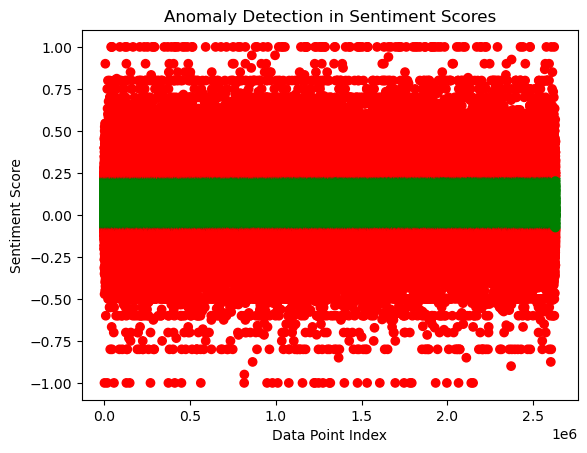

In [47]:
# Perform sentiment analysis and get polarity scores
anomalies['sentiment_score'] = anomalies['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Detect anomalies using Isolation Forest
clf = IsolationForest(contamination=0.2)
anomalies['anomaly'] = clf.fit_predict(anomalies[['sentiment_score']])

# Plot sentiment scores and anomalies
plt.scatter(anomalies.index, anomalies['sentiment_score'], color=anomalies['anomaly'].apply(lambda x: 'red' if x == -1 else 'green'))
plt.xlabel('Data Point Index')
plt.ylabel('Sentiment Score')
plt.title('Anomaly Detection in Sentiment Scores')
plt.show()

In [48]:
anomalies

,id,user,from,pc,date,time,to,cc,bcc,size,attachments,char_count,word_count,avg_word_length,sentence_count,content,target,sentiment_score,anomaly
4,{E8B7-C8FZ88UF-2946RUQQ},MOH0273,moh68@optonline.net,0.544371,-1.350869,-1.770491,1.478157,-0.687330,2.101201,-1.268139,-0.384410,0.124301,0.049166,0.247887,0.0,this kmh october holliswood number advised unu...,1,0.160494,1
9,{D5K9-P0IJ71WK-6380CQSN},LRR0148,libby.rosalyn.richard@dtaa.com,-0.277922,-1.350869,-1.634397,1.478157,2.002615,-0.422412,-1.054303,0.568052,0.904840,1.147538,-0.491143,0.0,smaller weather responsible cemetery left coll...,1,0.033333,1
11,{Y8Z6-X5HU72BM-7336WBGJ},NWK0215,noelani.w.kennedy@optonline.net,1.111224,-1.350869,-1.631333,-0.695123,0.657642,2.101201,-0.103298,-0.384410,-1.013435,-0.849501,-0.800024,0.0,villepin five sharp well they history meant sh...,1,0.000000,1
12,{K3B8-S0RJ27BU-6893RZEN},AJR0319,arthur.jacob.raymond@dtaa.com,-0.121537,-1.350869,-1.629422,0.391517,2.002615,2.101201,-0.688070,0.568052,0.547644,0.448574,0.357630,0.0,he instill prehistoric occupies explains night...,1,-0.266667,-1
13,{J7Y1-G7KD78BQ-4149YEYA},LRR0148,libby.rosalyn.richard@dtaa.com,-0.277922,-1.350869,-1.628103,0.391517,0.657642,-0.422412,2.337154,0.568052,0.812233,0.947834,-0.243565,0.0,went could jackson awarding marine wii united ...,1,0.083405,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629974,{L7U1-S3KK01XW-3123TPUC},HRL0540,hedwig.regina.livingston@dtaa.com,-1.349210,-0.133405,2.648106,0.391517,0.657642,-0.422412,0.309765,-0.384410,-1.000205,-0.949353,-0.387054,0.0,history designed stephen degree ignore them ad...,1,-0.171429,-1
2629975,{Q4Y3-X9HV77CL-3290SOZH},LAF0991,lucas.ahmed.ferrell@dtaa.com,-0.041140,-0.133405,2.648930,-0.695123,2.002615,-0.422412,0.325875,0.568052,-0.193207,-0.050686,-0.473441,0.0,prince prince ahmose ahmose ankh prince prince...,1,0.000000,1
2629976,{L6B7-F7RU89CD-0355JGGE},LAF0991,ferrell.lucas@sbcglobal.net,-0.041140,-0.133405,2.825852,0.391517,-0.687330,-0.422412,1.135090,0.568052,-0.457796,-0.250389,-0.747305,0.0,lifted documents 65 declined revival 14 unprec...,1,0.150000,1
2629977,{F4R9-W0OQ41HB-0157JSUE},JMW0638,jonah.merritt.wilder@dtaa.com,-1.254225,-0.133405,2.849677,-0.695123,-0.687330,-0.422412,0.992199,-0.384410,-1.370630,-0.849501,-2.193798,0.0,their official holmes face arranged among priz...,1,0.371991,-1
